Loading and Preprocessing Dataset

In [3]:
import os

# شوف الملفات اللي موجودة
print(os.listdir('/kaggle/input/food-101'))


['food-101']


In [4]:
data_path = '/kaggle/input/food-101/food-101'
print(os.listdir('/kaggle/input/food-101/food-101'))

['meta', 'README.txt', 'license_agreement.txt', 'test', 'train']


In [5]:
import os, shutil, stat, collections
from collections import defaultdict

In [6]:
# 1) استيراد المكتبات
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2025-04-28 16:45:27.479976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745858727.679470      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745858727.736600      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# 3) تجهيز التوازي (multiprocessing)
num_processes = 6
pool = mp.Pool(processes=num_processes)

In [8]:
# 4) بناء خريطة الكلاسات
class_to_ix, ix_to_class = {}, {}
with open(os.path.join(data_path, 'meta', 'classes.txt'), 'r') as f:
    classes = [l.strip() for l in f]
    class_to_ix = {c:i for i,c in enumerate(classes)}
    ix_to_class = {i:c for i,c in enumerate(classes)}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


# Data Augmentation للـ Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # 🔥 هنا ناخد 10% من الـ train كـ validation
)

# توليد الداتا أثناء التدريب
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Test Generator (بمجلد test)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 68175 images belonging to 101 classes.
Found 7575 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [10]:
print(f"عدد الكلاسات: {len(class_to_ix)}")
print(list(class_to_ix.items())[:5])  # اعرض أول 5


عدد الكلاسات: 101
[('apple_pie', 0), ('baby_back_ribs', 1), ('baklava', 2), ('beef_carpaccio', 3), ('beef_tartare', 4)]


Visualization Tools

In [11]:
!pip install ipywidgets

In [12]:
import random
from PIL import Image
from ipywidgets import interact # Import interact from ipywidgets



@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'train', class_name)  # للتدريب

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

In [13]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'test', class_name)

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

Image Augmentation

In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# عدد الكلاسات
n_classes = len(sorted_class_to_ix)

# إعداد الـ train_datagen مع Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # 🛡️ هنا الفرق الكبير: تقسيم داخلي Validation
)

# إعداد الـ validation/test datagen (بدون augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

# إعداد الـ Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # ⚡ Train فقط
)

valid_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'  # ⚡ Validation فقط
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 68175 images belonging to 101 classes.
Found 7575 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


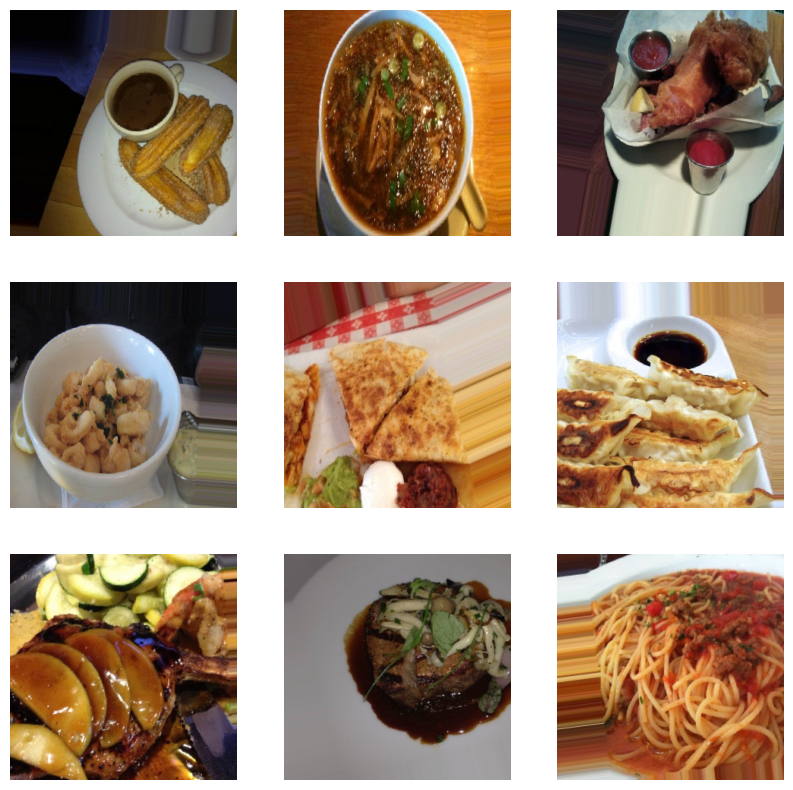

In [15]:
# عرض صور من الـ train_generator مع Augmentation
def plot_augmented_images(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

plot_augmented_images(train_generator)

Training

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
import os

In [17]:
# تأكد من وجود GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
# Clear Session
tf.keras.backend.clear_session()

# تحميل InceptionV3 بدون الطبقة الأخيرة
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))


I0000 00:00:1745767487.295675      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [19]:
# بناء الطبقات الجديدة
x = base_model.output
x = AveragePooling2D(pool_size=(8,8))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(
    n_classes,                  # عدد الكلاسات
    activation='softmax',
    kernel_initializer='glorot_uniform',
    kernel_regularizer=l2(0.0005)
)(x)

In [ ]:
# بناء الموديل النهائي
model = Model(inputs=base_model.input, outputs=predictions)

# إعداد Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = ModelCheckpoint('/kaggle/working/best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger('/kaggle/working/training_log.csv')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Learning Rate Scheduler
def schedule(epoch):
    if epoch < 15:
        return 0.01
    elif epoch < 28:
        return 0.002
    else:
        return 0.0004

lr_scheduler_cb = LearningRateScheduler(schedule)

# steps_per_epoch & validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# التدريب
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=32,
    verbose=1,
    callbacks=[lr_scheduler_cb, csv_logger_cb, checkpoint_cb, early_stopping_cb]
)

Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745767955.819051     153 service.cc:148] XLA service 0x7b1a80004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745767955.819863     153 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745767959.295643     153 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745767990.087240     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.3517 - loss: 2.8477
Epoch 1: val_loss improved from inf to 2.26885, saving model to /kaggle/working/best_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1990s 900ms/step - accuracy: 0.3518 - loss: 2.8474 - val_accuracy: 0.4771 - val_loss: 2.2689 - learning_rate: 0.0100
Epoch 2/32
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 8:30 240ms/step - accuracy: 0.4688 - loss: 2.1487

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.26885
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4688 - loss: 2.1487 - val_accuracy: 0.4348 - val_loss: 2.3769 - learning_rate: 0.0100
Epoch 3/32
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6130 - loss: 1.6192
Epoch 3: val_loss improved from 2.26885 to 2.20075, saving model to /kaggle/working/best_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1672s 783ms/step - accuracy: 0.6131 - loss: 1.6191 - val_accuracy: 0.4999 - val_loss: 2.2007 - learning_rate: 0.0100
Epoch 4/32
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 8:07 229ms/step - accuracy: 0.6875 - loss: 1.4380
Epoch 4: val_loss improved from 2.20075 to 1.62180, saving model to /kaggle/working/best_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 2s 715us/step - accuracy: 0.6875 - loss: 1.4380 - val_accuracy: 0.4783 - val_loss: 1.6218 - learning_rate: 0.0100
Epoch 5/32
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.6847 - loss: 1.3335
Epoch 5: val_loss improved from 1.62180 to

In [19]:
from tensorflow.keras.models import load_model
# Clear any previous sessions
tf.keras.backend.clear_session()

# Load your saved model
model = load_model('/kaggle/input/fine-tuned/fine_tuned_model_continued.keras')
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [ ]:
# Model Fine-tuning

# Load the model
model = load_model('/kaggle/input/best-model/best_model.keras')

# فتح آخر 30 طبقة فقط
for layer in model.layers[:-30]:
    layer.trainable = False
for layer in model.layers[-30:]:
    layer.trainable = True

# إعداد Optimizer
opt = SGD(learning_rate=8e-5, momentum=0.9)

# إعادة Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = ModelCheckpoint('/kaggle/working/fine_tuned_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger('/kaggle/working/fine_tuned_log.csv')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def schedule(epoch):
    if epoch < 2:
        return 4e-4    # 0.0004
    elif epoch < 12:
        return 8e-5    # 0.00008
    elif epoch < 20:
        return 1.6e-5  # 0.000016
    else:
        return 3.2e-6  # 0.0000032


lr_scheduler_cb = LearningRateScheduler(schedule)

# Train
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=32,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb],
    verbose=1
)


Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745791654.505189      91 service.cc:148] XLA service 0x7a7658060e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745791654.505930      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745791656.572329      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2130 ━━━━━━━━━━━━━━━━━━━━ 2:52 81ms/step - accuracy: 0.7812 - loss: 0.8992   

I0000 00:00:1745791665.881871      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8100 - loss: 0.8050
Epoch 1: val_loss improved from inf to 1.19235, saving model to /kaggle/working/fine_tuned_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 2131s 987ms/step - accuracy: 0.8100 - loss: 0.8050 - val_accuracy: 0.7315 - val_loss: 1.1923 - learning_rate: 4.0000e-04
Epoch 2/32
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 2:46 78ms/step - accuracy: 0.8125 - loss: 0.6462

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.19235
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8125 - loss: 0.6462 - val_accuracy: 0.6522 - val_loss: 1.2413 - learning_rate: 4.0000e-04
Epoch 3/32
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8262 - loss: 0.7588
Epoch 3: val_loss improved from 1.19235 to 1.15390, saving model to /kaggle/working/fine_tuned_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1596s 747ms/step - accuracy: 0.8262 - loss: 0.7588 - val_accuracy: 0.7386 - val_loss: 1.1539 - learning_rate: 8.0000e-05
Epoch 4/32
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 2:41 76ms/step - accuracy: 0.8750 - loss: 0.5978
Epoch 4: val_loss did not improve from 1.15390
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.8750 - loss: 0.5978 - val_accuracy: 0.6522 - val_loss: 1.3741 - learning_rate: 8.0000e-05
Epoch 5/32
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8290 - loss: 0.7508
Epoch 5: val_loss did not improve from 1.15390
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 16

In [27]:
# استيراد المكتبات
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger

# 1) تحميل آخر موديل محفوظ
model = load_model('/kaggle/working/fine_tuned_model.keras')

# 2) فتح آخر 30 طبقة فقط للتدريب
for layer in model.layers[:-30]:
    layer.trainable = False
for layer in model.layers[-30:]:
    layer.trainable = True

# 3) إعداد Optimizer
opt = SGD(learning_rate=8e-5, momentum=0.9)

# 4) إعادة Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 5) Callbacks
checkpoint_cb = ModelCheckpoint('/kaggle/working/fine_tuned_model_continued.keras', save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger('/kaggle/working/fine_tuned_log_continued.csv')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def schedule(epoch):
    # لأننا كملين من بعد 11 تقريبًا، فنعمل حساب ده:
    if epoch < 2:  
        return 8e-5    # أول Epochين هيبقوا 8e-5 (نكمل عادي)
    elif epoch < 10:  
        return 1.6e-5  # بعدين ننزل السرعة
    else:
        return 3.2e-6  # في الآخر Learning Rate صغير جدًا

lr_scheduler_cb = LearningRateScheduler(schedule)

# 6) مواصلة Training (نكمل باقي الـ Epochs)
history_finetune_continue = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # مثلا نكمل 10-20 Epoch كمان
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb, csv_logger_cb],
    verbose=1
)


Epoch 1/20
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8354 - loss: 0.7332
Epoch 1: val_loss improved from inf to 1.17278, saving model to /kaggle/working/fine_tuned_model_continued.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1661s 769ms/step - accuracy: 0.8354 - loss: 0.7332 - val_accuracy: 0.7292 - val_loss: 1.1728 - learning_rate: 8.0000e-05
Epoch 2/20
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 2:45 78ms/step - accuracy: 0.8125 - loss: 0.7317
Epoch 2: val_loss improved from 1.17278 to 1.12567, saving model to /kaggle/working/fine_tuned_model_continued.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8125 - loss: 0.7317 - val_accuracy: 0.7391 - val_loss: 1.1257 - learning_rate: 8.0000e-05
Epoch 3/20
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.8329 - loss: 0.7362
Epoch 3: val_loss did not improve from 1.12567
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1591s 745ms/step - accuracy: 0.8329 - loss: 0.7362 - val_accuracy: 0.7313 - val_loss: 1.1620 - learning_rate: 1.6000e-05
E

optimize

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load latest model
model = load_model('/kaggle/input/fine-tuned/fine_tuned_model_continued.keras')

# فتح آخر 50 طبقة
for layer in model.layers[:-50]:
    layer.trainable = False
for layer in model.layers[-50:]:
    layer.trainable = True

# Optimizer
opt = SGD(learning_rate=1e-5, momentum=0.9)

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = ModelCheckpoint('/kaggle/working/optimized_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger('/kaggle/working/optimized_training_log.csv')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-6)

# Learning Rate ثابت
def schedule(epoch):
    return 1e-5

lr_scheduler_cb = LearningRateScheduler(schedule)

# Data Augmentation أقوى
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.8, 1.2],
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.1  # زي ما كنا عاملين
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Train
history_optimize = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint_cb, csv_logger_cb, early_stopping_cb, reduce_lr_cb, lr_scheduler_cb],
    verbose=1
)


Found 68175 images belonging to 101 classes.
Found 7575 images belonging to 101 classes.
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745859073.427923     156 service.cc:148] XLA service 0x7f8c54002670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745859073.428740     156 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745859075.616496     156 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2130 ━━━━━━━━━━━━━━━━━━━━ 3:13 91ms/step - accuracy: 0.8281 - loss: 0.8970   

I0000 00:00:1745859086.782348     156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7993 - loss: 0.8665
Epoch 1: val_loss improved from inf to 1.24761, saving model to /kaggle/working/optimized_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 3049s 1s/step - accuracy: 0.7993 - loss: 0.8665 - val_accuracy: 0.7124 - val_loss: 1.2476 - learning_rate: 1.0000e-05
Epoch 2/40
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 3:04 87ms/step - accuracy: 0.7812 - loss: 0.7696

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.24761
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7812 - loss: 0.7696 - val_accuracy: 0.7391 - val_loss: 1.3709 - learning_rate: 1.0000e-05
Epoch 3/40
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8000 - loss: 0.8574
Epoch 3: val_loss improved from 1.24761 to 1.21885, saving model to /kaggle/working/optimized_model.keras
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 1866s 874ms/step - accuracy: 0.8000 - loss: 0.8574 - val_accuracy: 0.7217 - val_loss: 1.2188 - learning_rate: 1.0000e-05
Epoch 4/40
   1/2130 ━━━━━━━━━━━━━━━━━━━━ 2:56 83ms/step - accuracy: 0.8750 - loss: 0.6917
Epoch 4: val_loss did not improve from 1.21885
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.8750 - loss: 0.6917 - val_accuracy: 0.6522 - val_loss: 1.2974 - learning_rate: 1.0000e-05
Epoch 5/40
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8008 - loss: 0.8523
Epoch 5: val_loss did not improve from 1.21885
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 188